<a href="https://colab.research.google.com/github/payaldas30/Impulse-NITK/blob/main/Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
file_path = '/content/drive/MyDrive/Impulse/EEG_Data/train_data/Complex_Partial_Seizures/1004.npy'
eeg_signal = np.load(file_path)

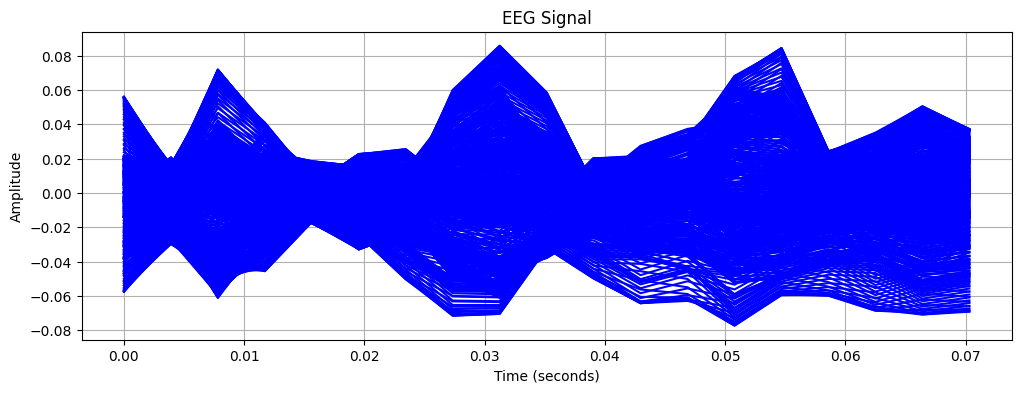

In [ ]:
import matplotlib.pyplot as plt
sampling_rate = 256
time = np.arange(0, len(eeg_signal)) / sampling_rate
plt.figure(figsize=(12, 4))
plt.plot(time, eeg_signal, color='blue')
plt.title("EEG Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pip install PyWavelets


In [ ]:
import pywt
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, medfilt
from skimage.restoration import denoise_tv_chambolle

def load_data_from_folder(folder_path):
    noisy_data = []
    ground_truth = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return np.array([]), np.array([]), np.array([])

    label_map = {'Complex_Partial_Seizures': 0,
                 'Electrographic_Seizures': 1,
                 'Normal': 2,
                 'Video_detected_Seizures': 3}

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = label_map.get(subfolder, -1)
            if label == -1:
                continue

            for file_name in os.listdir(subfolder_path):
                if file_name.endswith(".npy"):
                    file_path = os.path.join(subfolder_path, file_name)
                    try:
                        data = np.load(file_path)
                        noisy_data.append(data[0])
                        ground_truth.append(data[1])
                        labels.append(label)
                    except Exception as e:
                        print(f"Error loading {file_name}: {e}")

    return np.array(noisy_data), np.array(ground_truth), np.array(labels)


def preprocess_signal(signal, window_length=11, polyorder=3):
    return savgol_filter(signal, window_length, polyorder)

def wavelet_denoise(signal, wavelet='db8', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    thresholded_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return pywt.waverec(thresholded_coeffs, wavelet)


def median_filter_denoise(signal, kernel_size=3):
    return medfilt(signal, kernel_size)


def tv_denoise(signal, weight=0.1):
    signal_norm = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    denoised_signal = denoise_tv_chambolle(signal_norm, weight=weight)
    return denoised_signal * (np.max(signal) - np.min(signal)) + np.min(signal)


def combined_denoise(signal):
    signal = preprocess_signal(signal)
    denoised_wavelet = wavelet_denoise(signal, wavelet='db8', level=4)
    denoised_median = median_filter_denoise(denoised_wavelet, kernel_size=3)
    denoised_tv = tv_denoise(denoised_median, weight=0.1)
    return denoised_tv

def psnr(denoised_signal, ground_truth_signal):
    mse = mean_squared_error(ground_truth_signal, denoised_signal)
    if mse == 0:
        return float('inf')
    max_I = np.max(ground_truth_signal) - np.min(ground_truth_signal)
    return 10 * np.log10((max_I ** 2) / mse)

def main_pipeline():

    folder_path = "/content/drive/MyDrive/Impulse/EEG_Data/noisy_train_data"


    noisy_data, ground_truth, labels = load_data_from_folder(folder_path)


    if len(noisy_data) == 0:
        print("No data found in the folder or data could not be loaded correctly.")
        return

    denoised_data = []
    psnr_values = []

    for i in range(len(noisy_data)):
        denoised_signal = combined_denoise(noisy_data[i])
        denoised_data.append(denoised_signal)
        psnr_values.append(psnr(denoised_signal, ground_truth[i]))

    print("\nAverage PSNR:", np.mean(psnr_values))


    features = np.array(denoised_data)
    labels = np.hstack(labels)

    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_val)
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

if __name__ == "__main__":
    main_pipeline()



Average PSNR: 15.441224745103197

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.46      0.51       409
           1       0.00      0.00      0.00       126
           2       0.61      0.84      0.71       570

    accuracy                           0.60      1105
   macro avg       0.40      0.43      0.41      1105
weighted avg       0.53      0.60      0.55      1105



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
